In [1]:
## Kalau kerjakan di google colab, install dulu emcee dan corner
# !pip install -U emcee
# !pip install corner

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 46.2/46.2 kB 1.7 MB/s eta 0:00:00


In [1]:
import numpy as np
from matplotlib import pyplot as plt
import pandas as pd
import emcee
import corner
from scipy import stats

In [2]:
df_z = pd.read_csv("nz.csv")
df_z

,z_mid,nz,nz_error
0,-195.0,836,28.913665
1,-185.0,1008,31.749016
2,-175.0,1098,33.136083
3,-165.0,1252,35.383612
4,-155.0,1422,37.709415
5,-145.0,1679,40.975602
6,-135.0,1885,43.416587
7,-125.0,2171,46.593991
8,-115.0,2381,48.795492
9,-105.0,2585,50.842895


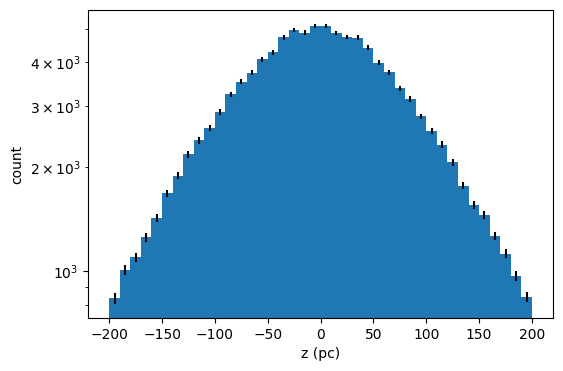

(3, 40)

In [4]:
zi = df_z['z_mid'].values
nzi = df_z['nz'].values
sigma_zi = df_z['nz_error'].values

dz = zi[1] - zi[0]

plt.figure(figsize=(6,4))
plt.bar(zi, nzi, dz, yerr=sigma_zi, align="center")
plt.xlabel("z (pc)")
plt.ylabel("count")
plt.yscale("log")
plt.show()

data = np.array([zi, nzi, sigma_zi])
data.shape

In [5]:
def log_prior(theta):
  n0 = theta[0]
  hz = theta[1]

  log_prior_n0 = stats.uniform.logpdf(n0, loc=4500, scale=1000)
  log_prior_hz = stats.uniform.logpdf(hz, loc=1, scale=199)
  return log_prior_n0 + log_prior_hz

def model(zi, n0, hz):
  return n0*np.exp(-np.power(zi/hz, 2))

def log_likelihood(theta, data):
  n0 = theta[0]
  hz = theta[1]

  zi = data[0]
  nzi = data[1]
  sigma_zi = data[2]

  nz_mod = model(zi, n0, hz)

  log_res = stats.norm.logpdf(nz_mod, loc=nzi, scale=sigma_zi)
  return np.sum(log_res)

def log_prob(theta, data):
  log_prior_val = log_prior(theta)
  if np.isinf(log_prior_val):
    return -np.inf
  return log_prior_val + log_likelihood(theta, data)

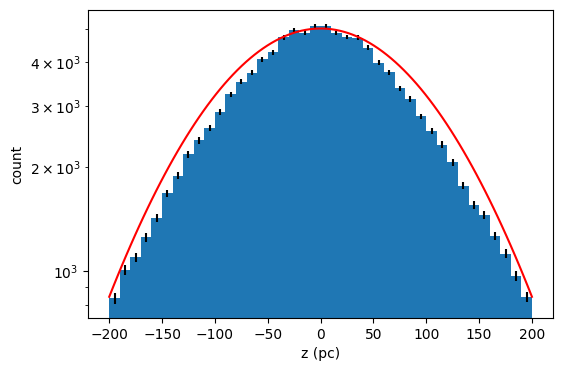

In [6]:
zs = np.linspace(-200, 200, 100)

n0 = 5000
hz = 150

nz_mod = model(zs, n0, hz)

plt.figure(figsize=(6,4))
plt.bar(zi, nzi, dz, yerr=sigma_zi, align="center")
plt.plot(zs, nz_mod, c='red')
plt.xlabel("z (pc)")
plt.ylabel("count")
plt.yscale("log")
plt.show()

In [7]:
n0 = 5000
hz = 200
theta = np.array([n0, hz])

print("prior", log_prior(theta))
print("likelihood", log_likelihood(theta, data))
print("posterior", log_prob(theta, data))

prior -12.201060103706629
likelihood -12171.178909561271
posterior -12183.379969664978


In [8]:
ndim = 2
nwalkers = 16

n0_0 = stats.uniform.rvs(size=nwalkers, loc=4500, scale=1000)
hz_0 = stats.uniform.rvs(size=nwalkers, loc=1, scale=199)

p0 = np.array([n0_0, hz_0]).T
p0

array([[4662.46345163,  173.5369005 ],
       [4682.74286788,  169.06729396],
       [5081.79813047,   38.93999859],
       [5334.75943589,  187.92915577],
       [5280.92200706,   63.15984755],
       [5002.49180826,   94.03191509],
       [5443.39708064,  112.400773  ],
       [5448.15896682,   59.29103826],
       [4709.41326711,   76.97239265],
       [5229.2633812 ,   38.07764732],
       [5443.0577335 ,  132.76224101],
       [5437.91241316,   82.41342705],
       [4939.19854008,   38.20678686],
       [5444.67521975,   65.7449647 ],
       [4913.84956539,   60.16859955],
       [5122.54347558,    5.55847921]])

In [9]:
for p0_i in p0:
  print(log_prob(p0_i, data))

-3204.6550473609855
-2567.9241171992066
-35150.404012245766
-12304.573955944516
-21845.92913763544
-8794.093096870161
-2728.950752623875
-23475.525008680506
-16867.095374589513
-35370.87867012805
-990.4382168918886
-12426.685800503325
-35824.58845268519
-20198.191175598087
-24290.154268875358
-53829.43223024926


In [10]:
nsteps = 100

sampler = emcee.EnsembleSampler(
    nwalkers, ndim, log_prob, args=(data,)
)

state = sampler.run_mcmc(p0, nsteps, progress=True);

  0%|          | 0/100 [00:00<?, ?it/s]

100%|██████████| 100/100 [00:00<00:00, 157.92it/s]


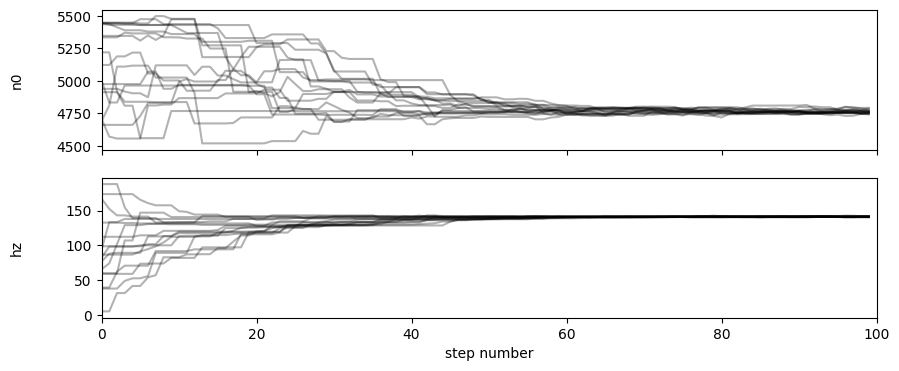

In [11]:
fig, axes = plt.subplots(ndim, figsize=(10, 4), sharex=True)
axes = np.atleast_1d(axes)
samples = sampler.get_chain()
labels = ["n0", "hz"]
for i in range(ndim):
    ax = axes[i]
    ax.plot(samples[:, :, i], "k", alpha=0.3)
    ax.set_xlim(0, len(samples))
    ax.set_ylabel(labels[i])
    ax.yaxis.set_label_coords(-0.1, 0.5)
axes[-1].set_xlabel("step number");

In [12]:
sampler.reset()

In [13]:
state = sampler.run_mcmc(state, 5000, progress=True);

100%|██████████| 5000/5000 [00:33<00:00, 151.46it/s]


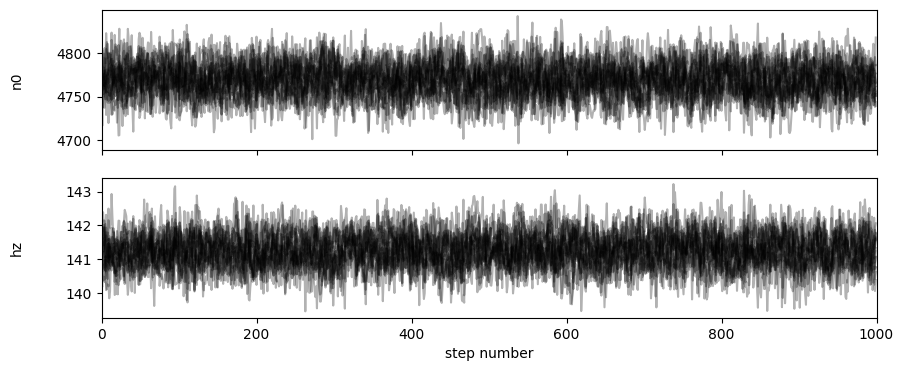

In [14]:
fig, axes = plt.subplots(ndim, figsize=(10, 4), sharex=True)
axes = np.atleast_1d(axes)
samples = sampler.get_chain(thin=5)
labels = ["n0", "hz"]
for i in range(ndim):
    ax = axes[i]
    ax.plot(samples[:, :, i], "k", alpha=0.3)
    ax.set_xlim(0, len(samples))
    ax.set_ylabel(labels[i])
    ax.yaxis.set_label_coords(-0.1, 0.5)
axes[-1].set_xlabel("step number");

In [15]:
flat_samples = sampler.get_chain(thin=5, flat=True)
flat_samples.shape

(16000, 2)

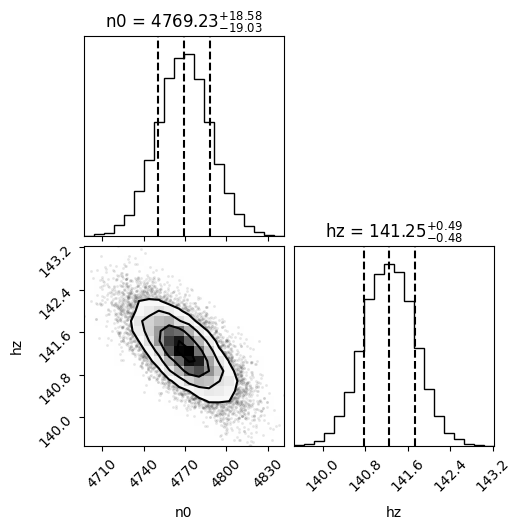

In [16]:
fig = corner.corner(
    flat_samples, labels=labels,
    quantiles=[0.16, 0.5, 0.84],
    show_titles=True,
    title_kwargs={"fontsize": 12},
);

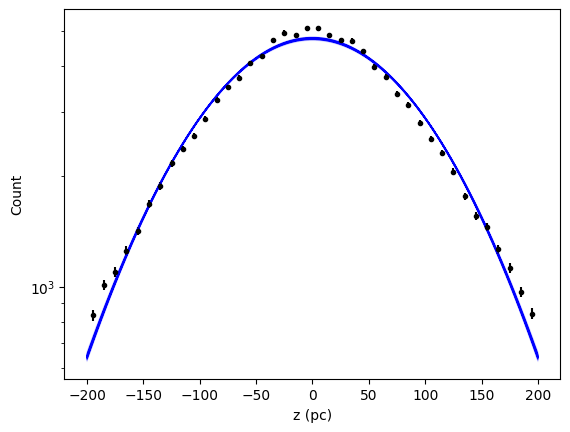

In [17]:
def sampled(theta, M):
    L, K = theta.shape
    indices = np.random.choice(L, size=M, replace=True)
    samples = theta[indices, :]
    return samples

theta_samples = sampled(flat_samples, 500)
zs = np.linspace(-200, 200, 100)
plt.errorbar(zi, nzi, yerr=sigma_zi, fmt=".k", capsize=0)
for theta_i in theta_samples:
  n0_i = theta_i[0]
  hz_i = theta_i[1]
  plt.plot(zs, model(zs, n0_i, hz_i), "b", alpha=0.01, lw=1)
plt.xlabel("z (pc)")
plt.ylabel("Count")
plt.yscale("log")
plt.show()

In [18]:
n0_samples = flat_samples[:,0]
hz_samples = flat_samples[:,1]

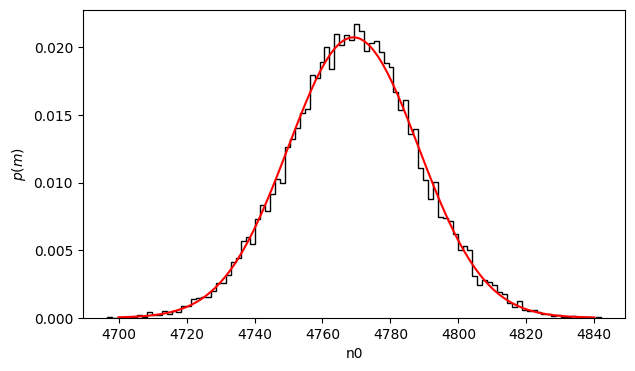

(4769.098598430703, 19.22351572937994)

In [19]:
n0_fit = stats.norm.fit(n0_samples)
n0_s = np.linspace(4700, 4840, 100)
p_n0 = stats.norm.pdf(n0_s, *n0_fit)

plt.figure(figsize=(7,4))
plt.hist(n0_samples, bins=100, density=True, color="k", histtype="step")
plt.plot(n0_s, p_n0, c="r")
plt.xlabel("n0")
plt.ylabel(r"$p(m)$")
plt.show()

n0_fit

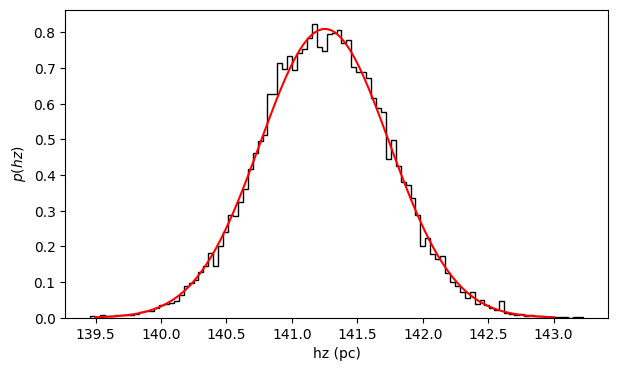

(141.25226823056036, 0.4925248457178587)

In [20]:
hz_fit = stats.norm.fit(hz_samples)
hz_s = np.linspace(139.5, 143, 100)
p_hz = stats.norm.pdf(hz_s, *hz_fit)

plt.figure(figsize=(7,4))
plt.hist(hz_samples, bins=100, density=True, color="k", histtype="step")
plt.plot(hz_s, p_hz, c="r")
plt.xlabel("hz (pc)")
plt.ylabel(r"$p(hz)$")
plt.show()

hz_fit